In [1]:
import sys, os
os.environ['NIXTLA_ID_AS_COL'] = '1'
sys.path.append('../../../aguacate-aljoan/')  # Adjust to the path where utils is located
from utils.data import obtener_nuevo_avocado, imputar_fechas

In [2]:
import pandas as pd

initial_avocado_df = imputar_fechas()
avocado_filtro = initial_avocado_df[initial_avocado_df['region_type'] == 'GreaterRegion']
avocado_filtro = avocado_filtro.sort_values(by=['Date', 'region']).reset_index(drop=True)
avocado_filtro['Date'] = pd.to_datetime(avocado_filtro['Date'])
avocado_filtro

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,region_type
0,51.0,2015-01-04,0.93,5777334.90,2843648.26,2267755.26,137479.64,528451.74,477193.38,47882.56,3375.80,conventional,2015.0,California,GreaterRegion
1,51.0,2015-01-04,1.24,142349.77,107490.73,25711.96,2.93,9144.15,9144.15,0.00,0.00,organic,2015.0,California,GreaterRegion
2,51.0,2015-01-04,1.02,3382800.12,467259.47,2059657.71,318102.38,537780.56,412779.64,111072.91,13928.01,conventional,2015.0,GreatLakes,GreaterRegion
3,51.0,2015-01-04,1.54,61615.10,3633.93,42963.06,0.00,15018.11,9763.55,5254.56,0.00,organic,2015.0,GreatLakes,GreaterRegion
4,51.0,2015-01-04,1.10,2578275.12,575245.44,1311502.53,181058.65,510468.50,429166.89,80986.81,314.80,conventional,2015.0,Midsouth,GreaterRegion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,0.0,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,2018.0,SouthCentral,GreaterRegion
2700,0.0,2018-03-25,1.23,4454904.40,2489234.81,333310.56,18460.82,1613898.21,1117431.16,484934.57,11532.48,conventional,2018.0,Southeast,GreaterRegion
2701,0.0,2018-03-25,1.45,121917.39,1929.39,18391.86,110.05,101486.09,85313.41,16172.68,0.00,organic,2018.0,Southeast,GreaterRegion
2702,0.0,2018-03-25,1.60,271723.08,26996.28,77861.39,117.56,166747.85,87108.00,79495.39,144.46,organic,2018.0,West,GreaterRegion


In [3]:
# Crear DataFrame para tipo 'organic'
organic_df = avocado_filtro[avocado_filtro['type'] == 'organic'].copy()
organic_df.rename(columns={'Date': 'ds'}, inplace=True)
organic_df['y'] = organic_df['Total Volume']
organic_df['unique_id'] = organic_df['type'] + '-' + organic_df['region']


# Crear DataFrame para tipo 'conventional'
conventional_df = avocado_filtro[avocado_filtro['type'] == 'conventional'].copy()
conventional_df.rename(columns={'Date': 'ds'}, inplace=True)
conventional_df['y'] = conventional_df['Total Volume']
conventional_df['unique_id'] = conventional_df['type'] + '-' + conventional_df['region']

In [4]:
organic_subset_df = organic_df[['ds', 'y', 'unique_id']].copy()
conventional_subset_df = conventional_df[['ds', 'y', 'unique_id']].copy()

In [16]:
# Agrupar por mes y unique_id, y sumar 'y' para cada combinación
organic_monthly_df = organic_subset_df.groupby([pd.Grouper(key='ds', freq='ME'), 'unique_id']).agg({'y': 'sum'}).reset_index()
conventional_monthly_df = conventional_subset_df.groupby([pd.Grouper(key='ds', freq='ME'), 'unique_id']).agg({'y': 'sum'}).reset_index()

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(
    models=[AutoARIMA(season_length = 12)],
    freq='M',
)

sf2 = StatsForecast(
    models=[AutoARIMA(season_length = 12)],
    freq='M',
)

organic_pred = sf.fit(organic_monthly_df)
conventional_pred = sf2.fit(conventional_monthly_df)

In [ ]:
forecast_organic_df = organic_pred.predict(h=12, level=[90])
forecast_conventional_df = conventional_pred.predict(h=12, level=[90])

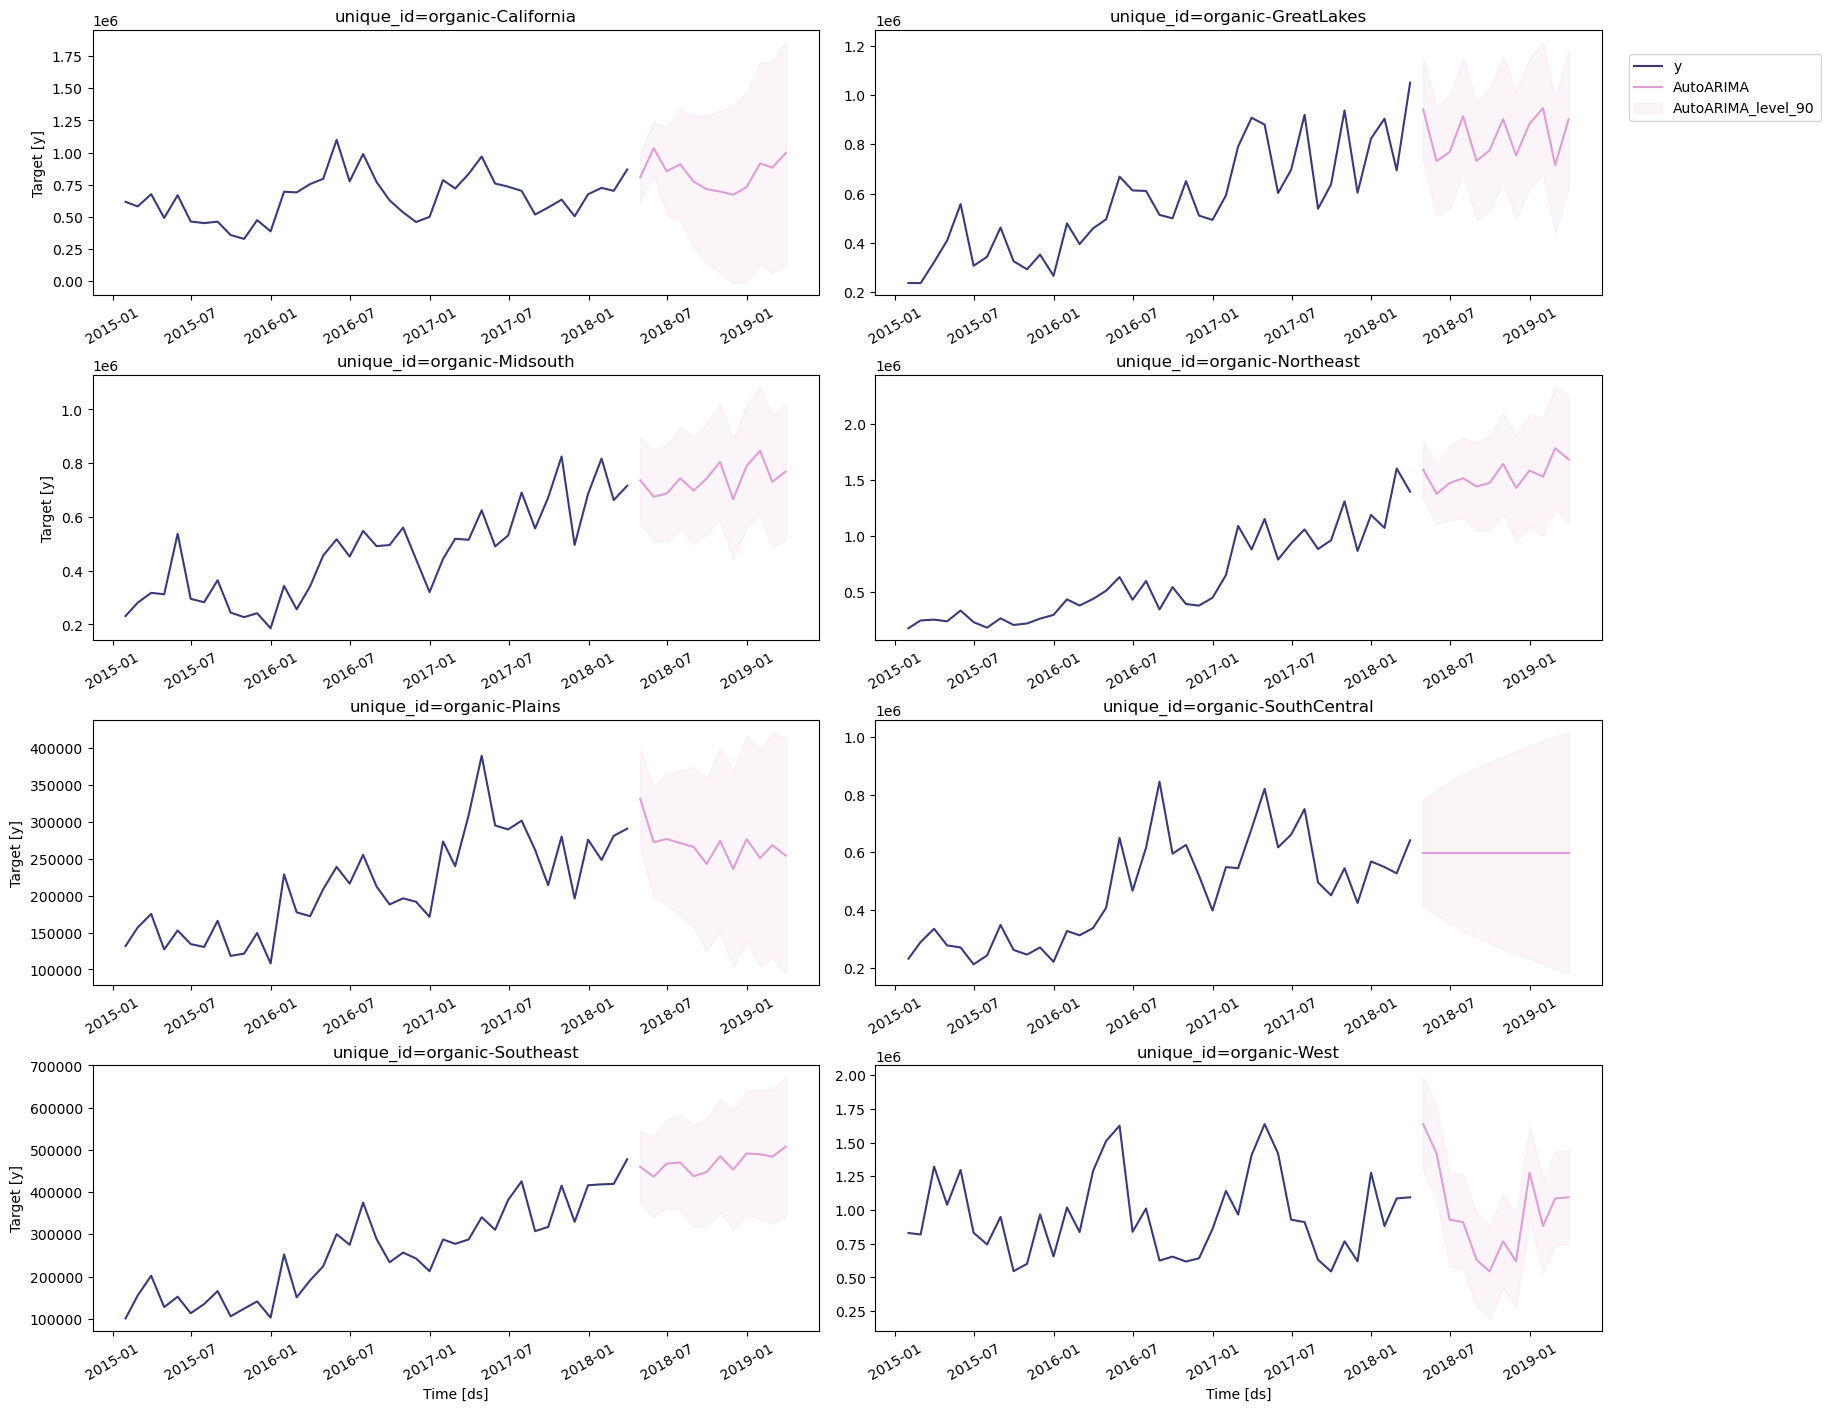

In [8]:
organic_pred.plot(organic_monthly_df, forecast_organic_df, level=[90])

In [9]:
# Filtrar los datos de entrenamiento y prueba para organic_monthly
organic_train = organic_monthly_df[organic_monthly_df['ds'] < '2018-01-01']
organic_test = organic_monthly_df[(organic_monthly_df['ds'] >= '2018-01-01')]

# Filtrar los datos de entrenamiento y prueba para conventional_monthly
conventional_train = conventional_monthly_df[conventional_monthly_df['ds'] < '2018-01-01']
conventional_test = conventional_monthly_df[(conventional_monthly_df['ds'] >= '2018-01-01')]



In [13]:
sf = StatsForecast(
    models=[AutoARIMA(season_length = 12)],
    freq='ME',
)

sf2 = StatsForecast(
    models=[AutoARIMA(season_length = 12)],
    freq='ME',
)

organic_pred = sf.fit(organic_train)
conventional_pred = sf2.fit(conventional_train)

In [14]:
forecast_organic_df = organic_pred.predict(h=12, level=[90])
forecast_conventional_df = conventional_pred.predict(h=12, level=[90])

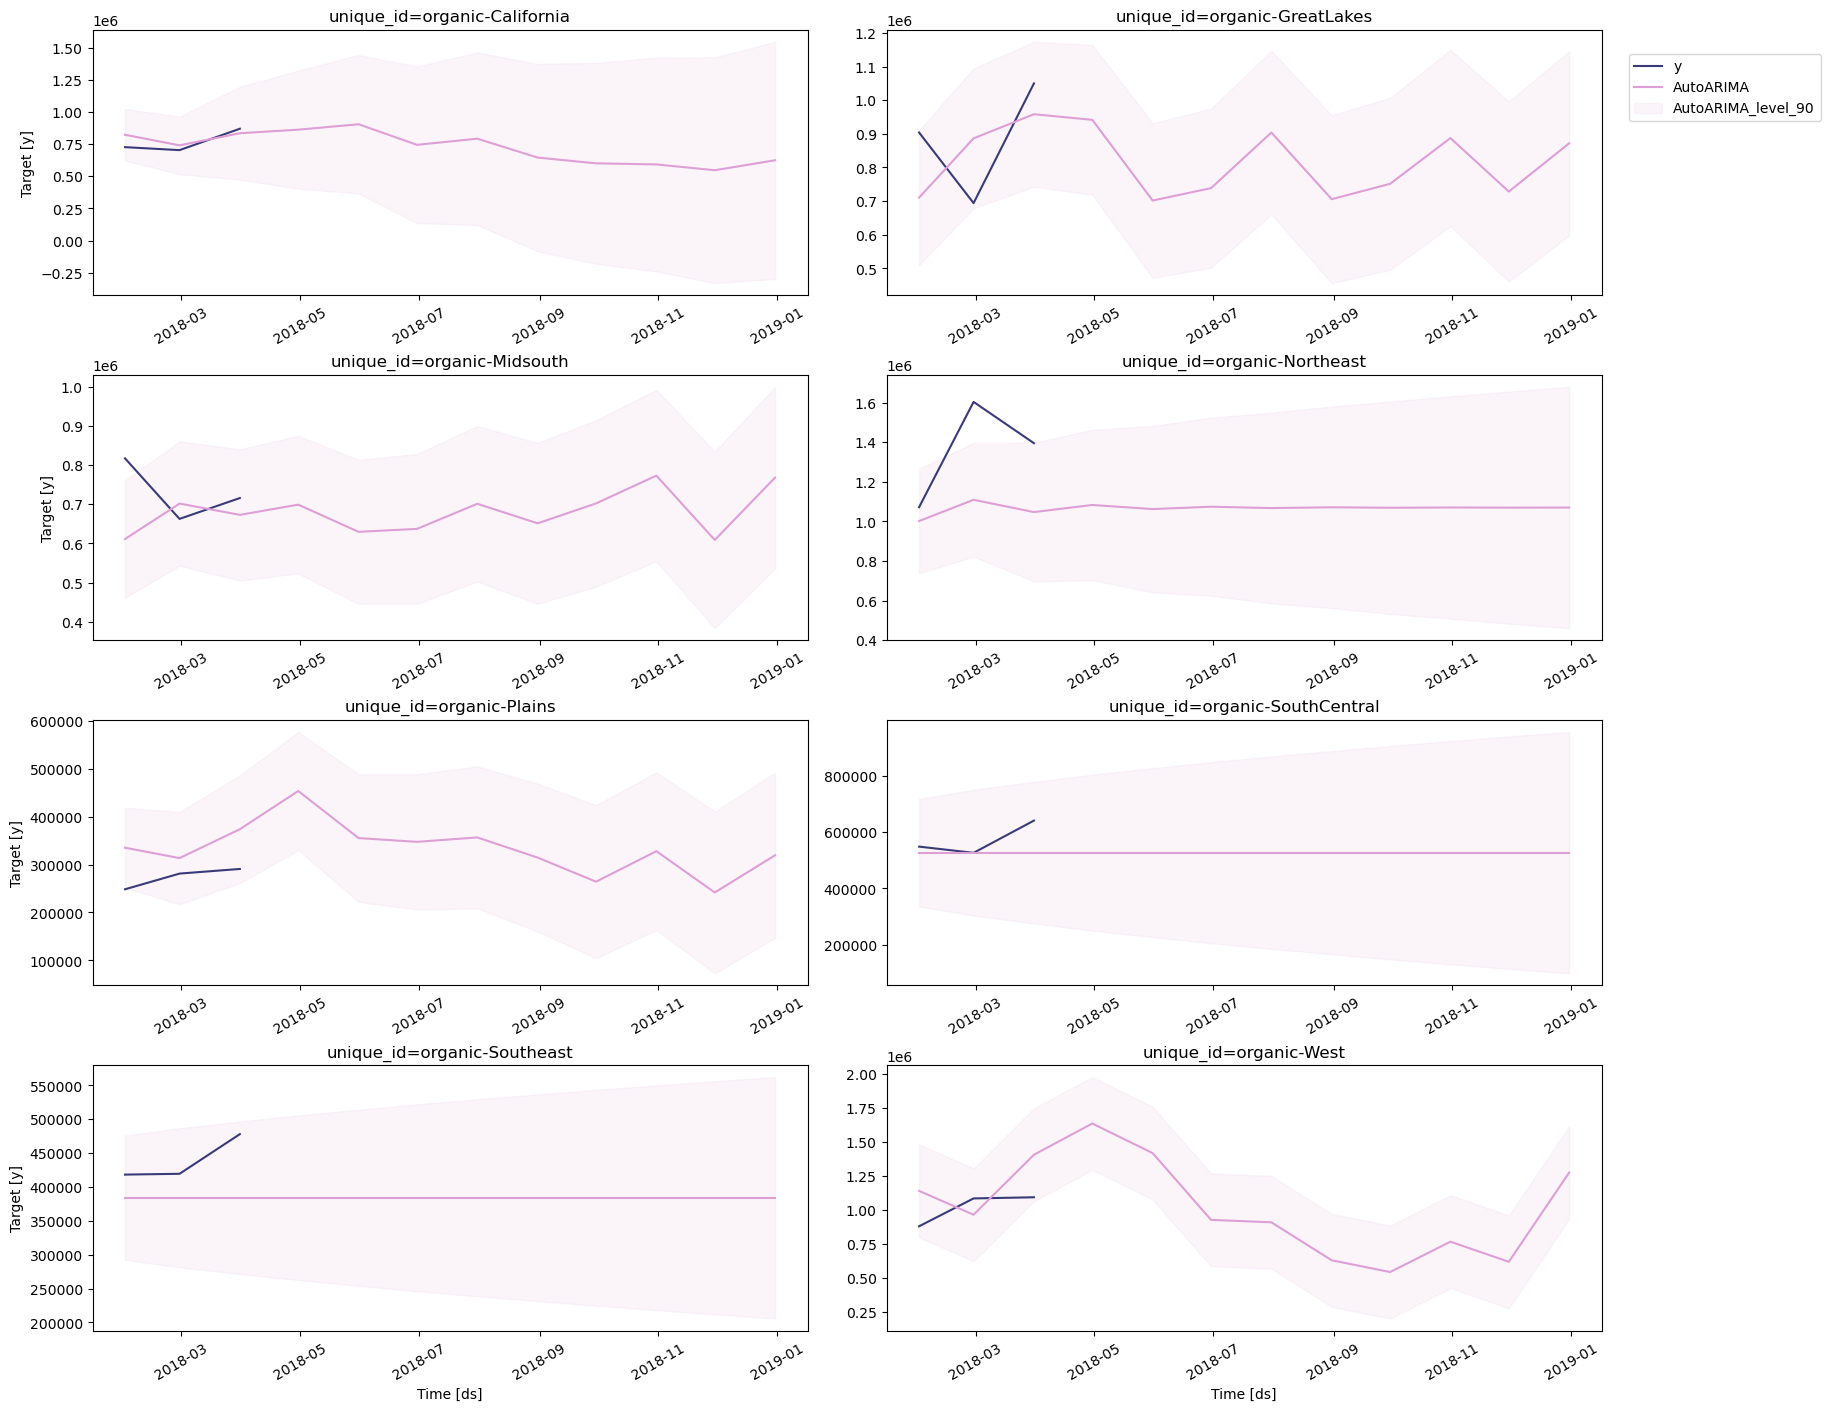

In [15]:
organic_pred.plot(organic_test, forecast_organic_df, level=[90])